In [13]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizerFast, TFBertModel
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    GlobalAveragePooling1D,
    SimpleRNN,
    Embedding,
    Masking,
    Bidirectional,
    Dropout,
)

In [2]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('훈련용 리뷰 개수 :',len(test_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000
훈련용 리뷰 개수 : 50000


In [7]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
train_data = train_data.dropna(how='any')

In [8]:
print(len(train_data))

146182


<Axes: xlabel='label'>

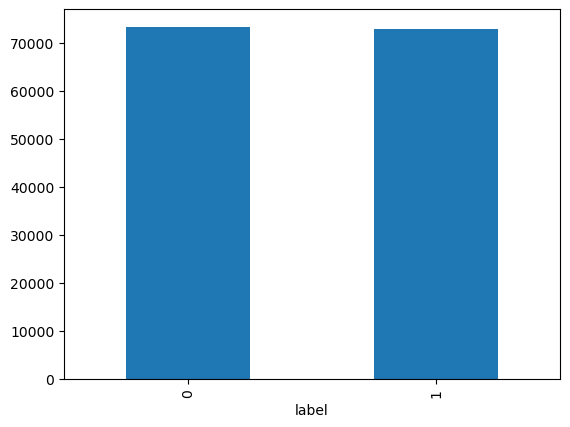

In [9]:
train_data['label'].value_counts().plot(kind = 'bar')

In [10]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72840


In [11]:
# 중복을 지워버리면 안된다.
train_data = train_data.dropna(how='any')

In [ ]:
# NaN을 지워지지 않으면 인코딩시 오류난다.
test_data = test_data.dropna(how='any')

# 토크나이저를 이용한 정수 인코딩

In [ ]:
# 이전 토크나이저하고 다르다. Fast가 있다.
tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base")

In [24]:
X_train_list = train_data['document'].tolist()
X_test_list = test_data['document'].tolist()
y_train = train_data['label'].tolist()
y_test = test_data['label'].tolist()

In [ ]:
# 이렇게 리스트를 통해서도 가능함. 앞에서는 함수를 만들어서 encode을 이용함
X_train = tokenizer(X_train_list, truncation=True, padding=True)

In [25]:
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [ ]:
# 토큰화 결과
print(X_train[0].tokens)

['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜증', '##나', '##네', '##요', '목소리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [27]:
# 토큰화에 대한 인코딩 결과
print(X_train[0].ids)

[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
# 세그먼트 확인
print(X_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
# 어텐션 마스크
print(X_train[0].attention_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


데이터 생성 및 모델 학습

In [30]:
# 데이터 셋 형태로 변환
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [31]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [33]:
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2, from_pt=True)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should p

In [ ]:
# 시간이 너무 많이 걸림
callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001,
    patience=2)

model.fit(
    train_dataset.shuffle(10000).batch(32), epochs=5, batch_size=64,
    validation_data = val_dataset.shuffle(10000).batch(64),
    callbacks = [callback_earlystop]
)

Epoch 1/5


 295/4569 [>.............................] - ETA: 15:35:18 - loss: 0.3643 - accuracy: 0.8362

KeyboardInterrupt: 

In [ ]:
# 나온결과의 전자가 오차, 후자가 정확도
model.evaluate(val_dataset.batch(1024))

In [ ]:
# 모델을 저장하고
model.save_pretrained('nsmc_model/bert-base')
tokenizer.save_pretrained('nsmc_model/bert-base')

In [ ]:
#테스트. 테스트할때는 테스트를 위한 패키지를 로드한다.
from transformers import TextClassificationPipeline

# 로드하기
loaded_tokenizer = BertTokenizerFast.from_pretrained('nsmc_model/bert-base')
loaded_model = TFBertForSequenceClassification.from_pretrained('nsmc_model/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

In [ ]:
# 테스트
text_classifier('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아')[0]